
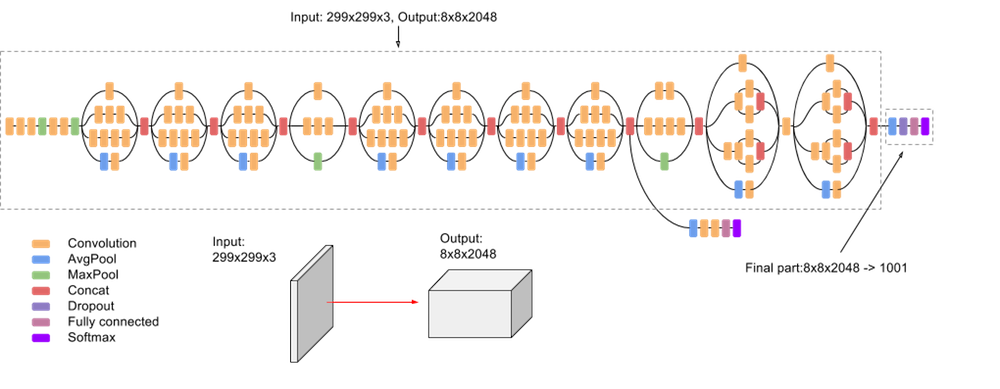

#InceptionV3 model je konvolutivna neuronska mreza koja je trenirana na skupu koji sadrzi 1000 klasa iz ImageNet skupa, treniran na preko milion slika.
InceptionV3 je model koji je treniran nedeljama na 8 Tesla K40 GPU i ima blizu 25 miliona parametara.

Input shape: 299x299x3 

Output shape: 8x8x2048

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import IPython.display as display
import PIL.Image
from tensorflow.keras.preprocessing import image
from scipy.ndimage.filters import gaussian_filter

In [21]:
image_path = 'https://images2.minutemediacdn.com/image/upload/c_crop,h_1193,w_2121,x_0,y_64/f_auto,q_auto,w_1100/v1565279671/shape/mentalfloss/578211-gettyimages-542930526.jpg'
ocean_animlas_image = 'https://www.leisurepro.com/blog/wp-content/uploads/2020/04/shutterstock_295429772.jpg'
seaside_image = 'https://www.wallpaperup.com/uploads/wallpapers/2012/12/27/26675/eca826ce2ebd7499cc4af933863e0de5-700.jpg'
some_beach_image = 'https://www.woovly.com/blog/wp-content/uploads/2019/11/Whitehaven-Beach-650x350.jpg'
belgrade_image = 'https://www.011info.com/uploads/Magazin/2017/12/06/57/900x600_pavle.jpg'

In [22]:
def load_image(url, target_size = [500,500]):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  image = PIL.Image.open(image_path)
  if target_size:
    image.thumbnail((target_size[0], target_size[1]))
  
  return np.array(image)
 

In [23]:
def normalize_image(image):
  image = 255*(image + 1.0) / 2.0
  return tf.cast(image, tf.uint8)

In [24]:
def save_image(image, filename):
  #pixels must be between 0-255
  image = np.clip(image, 0.0, 255.0)
  #convert to bytes
  image = image.astype(np.uint8)

  with open(filename,'wb') as file:
    PIL.Image.fromarray(image).save(file, 'jpeg')

In [25]:
def plot_image(image):
  try:
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display.display(PIL.Image.fromarray(np.array(image)))
  except:
    image = np.clip(image/255.0, 0.0, 1.0)

    plt.imshow(image, interpolation='lanczos')
    plt.show()

In [26]:
def plot_before_after(images, title=None):
  figure = plt.figure()
  plt_index = 1
  for img in images:
    figure.add_subplot(1, 2, plt_index)
    if plt_index==1:
      plt.title('Original image')
    else:
      plt.title(title)
    plt_index += 1
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    figure.set_size_inches(np.array(figure.get_size_inches()) * 2)
  plt.show()    


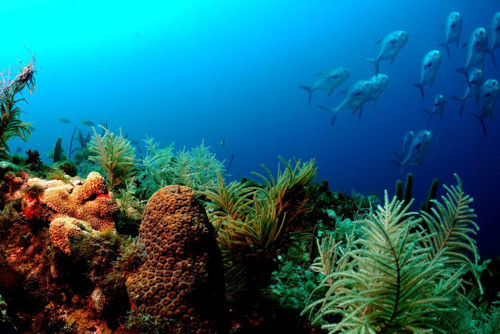

In [27]:
original_img = load_image(seaside_image)
plot_image(original_img)

Tensorflow verzija InceptionV3 modela ima 1001 klasu (jedna dodatna background klasa na poziciji 0).

In [28]:
inception_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

Arhitektura InceptionV3 modela je ogromna.
Za potrebe deepDream algoritma mozemo koristiti razlicite slojeve kako bi dobili razlicite obrasce.
Od interesa su nam slojevi gde su spojeni konvolutivni slojevi.
Postoji ih 11 i nazivaju se redom od 'mixed0' do 'mixed10'.
Zelimo da maksimizujemo aktivacione fukcije ovih slojeva.


In [29]:
choosen_layers = ['mixed5' , 'mixed7']
layers = [inception_model.get_layer(name).output for name in choosen_layers]

dream_model = tf.keras.Model(inputs= inception_model.input, outputs = layers )

###LOSS
Loss je suma funkcija aktivacija u odabranim slojevima. U deepdream algoritmu mi zelimo da maksimizujemo ove vrednosti kako bismo uocili obrasce ovih slojeva i to postizemo racunanjem gradijenta.

In [30]:
def calculate_loss(image, model):
  image_batch = tf.expand_dims(image, axis=0)
  layer_activations = model(image_batch)

  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for activation in layer_activations:
    loss = tf.math.reduce_mean(activation)
    losses.append(loss)

  return tf.reduce_sum(losses)

Racunamo gradijent na osnovu loss vrednosti i zatim gradijent dodajemo direktno na sliku.


In [31]:
@tf.function
def deepdream(model, image, step_size):
    with tf.GradientTape() as tape:
      tape.watch(image)
      loss = calculate_loss(image, model)

    gradients = tape.gradient(loss, image)

    gradients /= tf.math.reduce_std(gradients) + 1e-8 
    
    image = image + gradients*step_size
    image = tf.clip_by_value(image, -1, 1)
    
    return loss, image

In [32]:
def run_deep_dream_simple(model, image, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  image = tf.keras.applications.inception_v3.preprocess_input(image)

  for step in range(steps):
    loss, image = deepdream(model, image, step_size)
    
    if step % 50 == 0:
      display.clear_output(wait=True)
      plot_image(normalize_image(image))
      print ("Step {}, loss {}".format(step, loss))


  result = normalize_image(image)
  display.clear_output(wait=True)
  plot_image(result)
  print(loss)

  return result

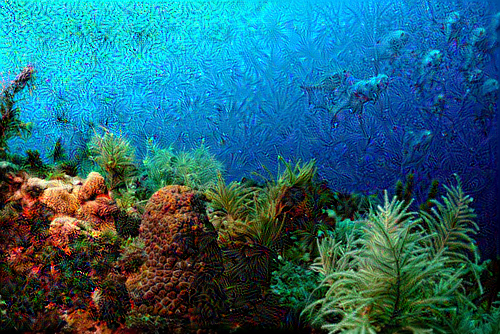

tf.Tensor(1.3864186, shape=(), dtype=float32)


In [33]:
dream_img = run_deep_dream_simple(model=dream_model, image=original_img,steps=100, step_size=0.02)


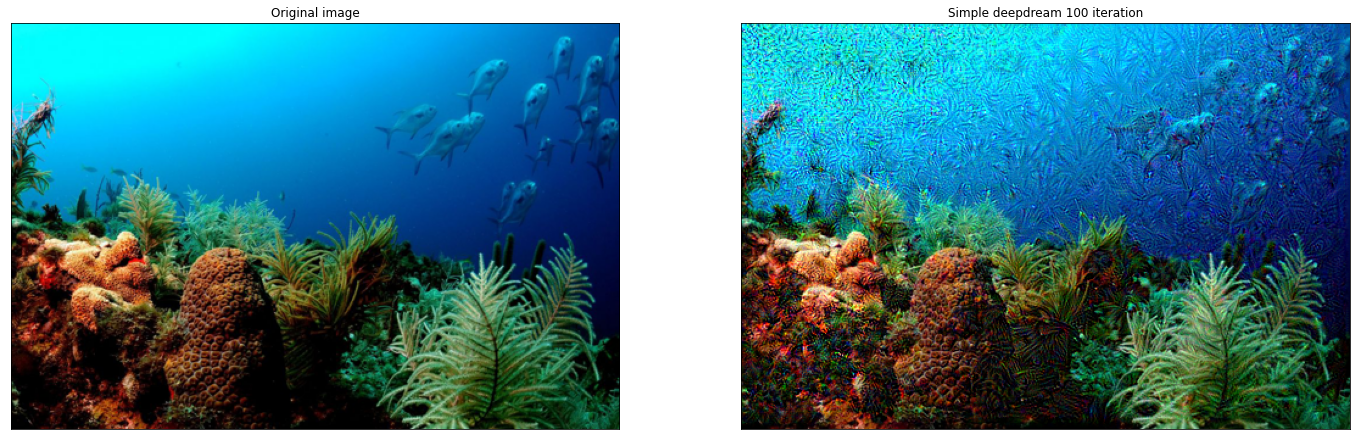

In [34]:
images_simple_deepdream = [original_img, dream_img]
plot_before_after(images_simple_deepdream, 'Simple deepdream 100 iteration')

**OCTAVE**

Kako bismo uocili sto bolje obrasce na prosledjenoj slici uvecavamo sliku zatim primenimo deepdream algoritam pa opet uvecamo sliku i primenimo algoritam i tako nekoliko puta kako bi dobili sto bolje rezultate. 

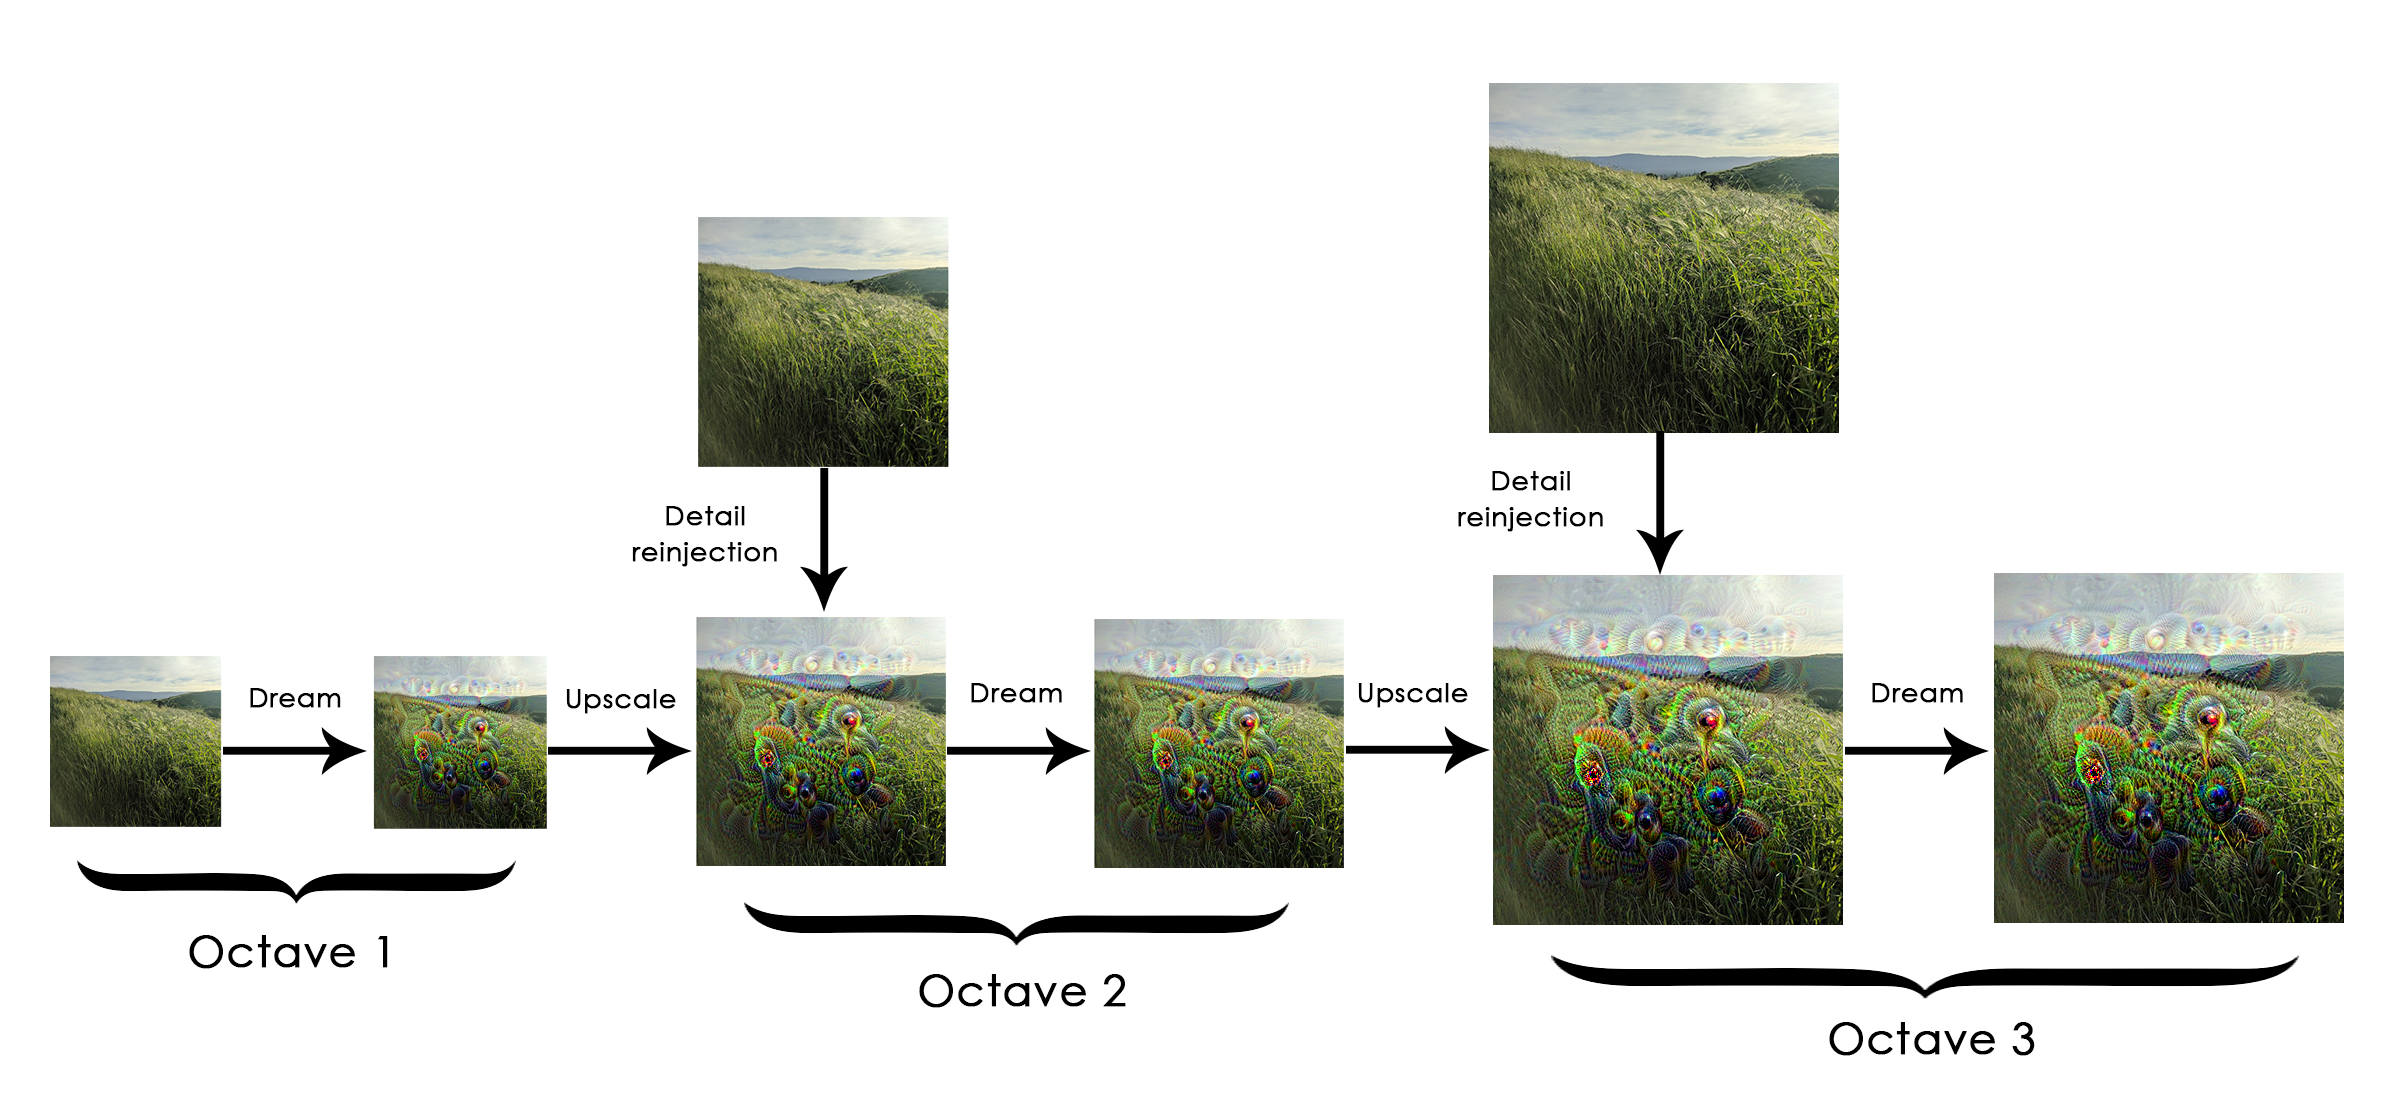

In [35]:
def deepdream_with_octave_downscaling(octave_scale, original_img, model, steps, step_size):

  image = tf.constant(np.array(original_img))
  base_shape = tf.cast(tf.shape(image)[:-1], tf.float32)

  for i in range(3):
    new_shape = tf.cast(base_shape*(octave_scale**i), tf.int32)
    image = tf.image.resize(image, new_shape).numpy()
    image = run_deep_dream_simple(model = model, image = image, steps=steps, step_size=step_size)


  for i in range(3):
    new_shape = tf.cast(base_shape/(octave_scale**i), tf.int32)
    image = tf.image.resize(image, new_shape).numpy()
    image = run_deep_dream_simple(model = model, image = image, steps=steps, step_size=step_size)


  display.clear_output(wait=True)
  plot_image(image)
  return image

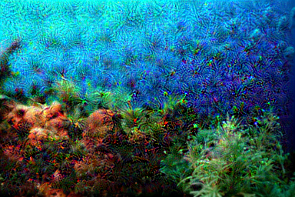

In [36]:
image = deepdream_with_octave_downscaling(1.3, original_img, dream_model, 100, 0.01)

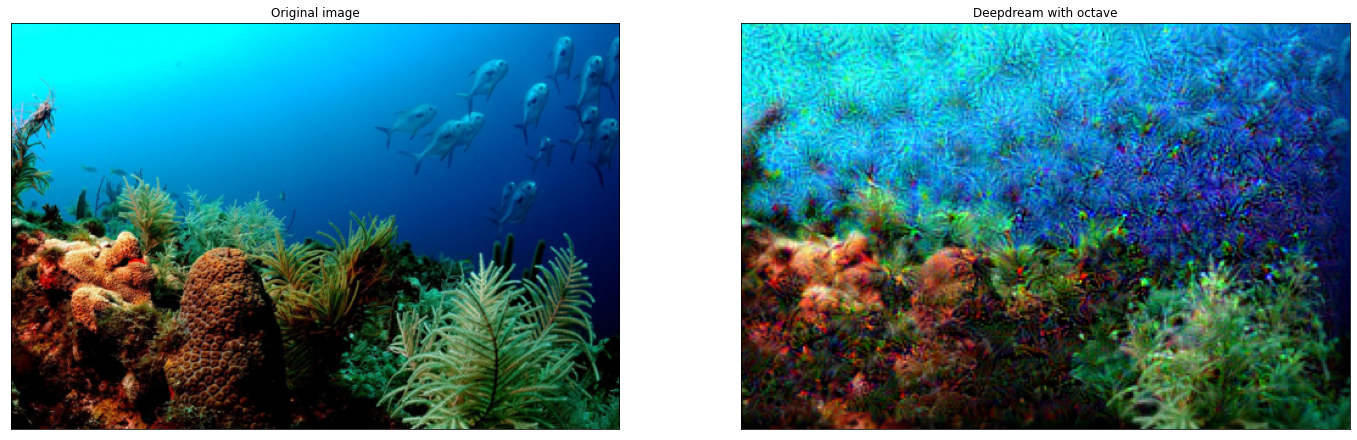

In [51]:
images_octave_deepdream = [original_img, image]
plot_before_after(images_octave_deepdream, 'Deepdream with octave')

In [40]:
@tf.function
def get_gradient(model, image, step_size):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = calculate_loss(image, model)

  gradients = tape.gradient(loss, image)

  return image, gradients

In [41]:
def normalize_gradient(x):
  
  x_min = x.min()
  x_max = x.max()

  x_norm = (x - x_min) / (x_max - x_min)
  
  return x_norm
  

In [42]:
def plot_gradient(gradient):
  
  # Normalize the gradient so it is between 0.0 and 1.0
  gradient_normalized = normalize_gradient(gradient)
  
  plt.imshow(gradient_normalized, interpolation='bilinear')
  plt.show()

In [43]:
def run_deep_dream_with_gaussian_filter(model, image, steps=100, step_size=0.01):

  image = tf.keras.applications.inception_v3.preprocess_input(image)

  for step in range(steps):
    image, gradients = get_gradient(model, image, step_size)
    
    sigma = (step * 2.0) / steps + 0.5
    grad_smooth1 = gaussian_filter(gradients, sigma=sigma)
    grad_smooth2 = gaussian_filter(gradients, sigma=sigma*2)
    grad_smooth3 = gaussian_filter(gradients, sigma=sigma*0.5)
    
    gradients = (grad_smooth1 + grad_smooth2 + grad_smooth3)

    step_size_scaled = step_size / (np.std(gradients) + 1e-8)

    image += gradients * step_size_scaled
    image = tf.clip_by_value(image, -1, 1)
    if step % 10 == 0:
      plot_image(normalize_image(image))
      #plot_gradient(gradients)
  
  result = normalize_image(image)
  display.clear_output(wait=True)
  plot_image(result)
  
  return result

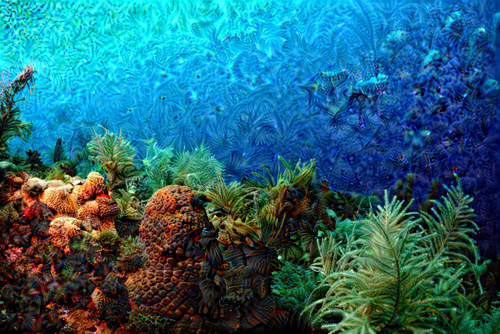

In [44]:
gradient_image=run_deep_dream_with_gaussian_filter(model=dream_model, image=original_img, steps=50, step_size=0.03)
 

In [45]:
from google.colab import drive

#drive.mount('drive')

In [46]:
def tiled_gradient(model, image, tile_size = 512):
  # Initialize the image gradients to zero.
  gradients = np.zeros_like(image)
 
  x_max , y_max, _ = image.shape

  xs = tf.range(0, x_max, tile_size)[:-1]
  if not tf.cast(len(xs), bool): #len(xs) < 0
    xs = tf.constant([0])
  ys = tf.range(0, y_max, tile_size)[:-1]
  if not tf.cast(len(ys), bool):
    ys = tf.constant([0])

  for x in xs:
    for y in ys:
      # Calculate the gradients for this tile.
      with tf.GradientTape() as tape:
        tape.watch(image)

        # Extract a tile out of the image.
        img_tile = image[x:x+tile_size, y:y+tile_size]
        loss = calculate_loss(img_tile, model)

      gradients = gradients + tape.gradient(loss, image)

  gradients /= tf.math.reduce_std(gradients) + 1e-8 

  return gradients

In [47]:
def run_deep_dream_with_gaussian_filter_with_tiles(model, image, steps=100, step_size=0.01, show_gradient=False):

  image = tf.keras.applications.inception_v3.preprocess_input(image)
  
  image=tf.convert_to_tensor(image)

  for step in range(steps):
    gradients = tiled_gradient(model, image)
    
    sigma = (step * 2.0) / steps + 0.5
    grad_smooth1 = gaussian_filter(gradients, sigma=sigma)
    grad_smooth2 = gaussian_filter(gradients, sigma=sigma*2)
    grad_smooth3 = gaussian_filter(gradients, sigma=sigma*0.5)
    
    gradients = (grad_smooth1 + grad_smooth2 + grad_smooth3)

    step_size_scaled = step_size / (np.std(gradients) + 1e-8)

    image += gradients * step_size_scaled
    
    image = tf.clip_by_value(image, -1, 1)
    
    if step % 10 == 0:
      msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
      print(msg.format(gradients.min(), gradients.max(), step_size_scaled))
      plot_gradient(gradients)

  result = normalize_image(image)
  display.clear_output(wait=True)
  print("Image after:")
  plot_image(result)  
  
  return result

Image after:


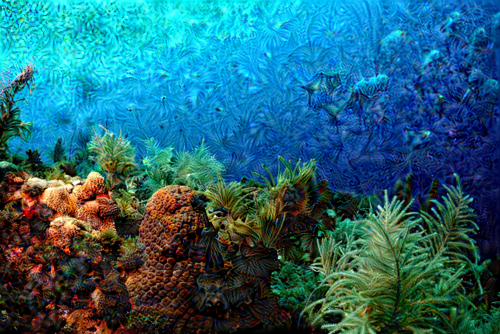

In [48]:
gradient_img=run_deep_dream_with_gaussian_filter_with_tiles(model=dream_model, image=original_img, steps=50, step_size=0.03, show_gradient=True)
 

In [49]:
images = [original_img, gradient_img]

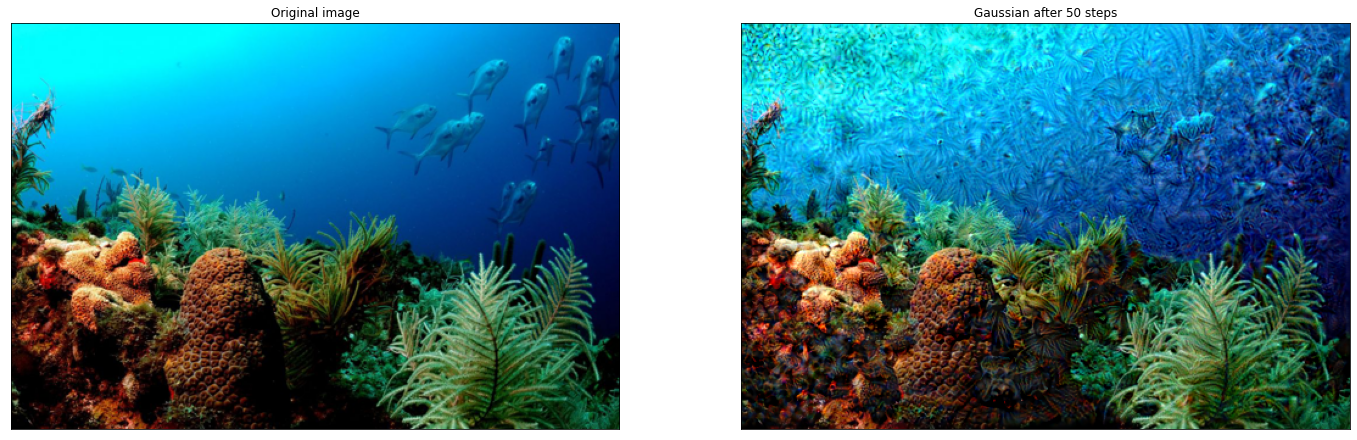

In [50]:
plot_before_after(images, 'Gaussian after 50 steps')